In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import simps,cumtrapz

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.multiclass import OneVsRestClassifier

from imblearn.over_sampling import ADASYN, SMOTE

In [2]:
all_param_df = pd.read_csv("../reduced_data/steam_all_param_merged_nan_removed_newclasses.csv")

In [3]:
all_param_df.dropna(inplace=True)
all_param_df.groupby("success_class")["appid"].nunique()

success_class
A      261
B      193
C      349
D      830
F    29984
Name: appid, dtype: int64

# Feature engineering

In [4]:
# define the target column
y = all_param_df["success_class"]

# create a list of columns to drop
drop_cols = ['appid','maxccu','success_class','suc_class','totaltags','followers',
             'recommendations','positive_x','positive_y','negative_x','negative_y']
x_data = all_param_df.drop(drop_cols, axis=1)

# transform "developer" and "publisher" columns from strings to codes 
x_data["developer"] = x_data["developer"].astype('category').cat.codes
x_data["publisher"] = x_data["publisher"].astype('category').cat.codes

# columns from 5 on are tags
tags = x_data.iloc[:,5:]
# normalize the tag values so they sum to 1
norm_tags = normalize(tags,norm='l1')
# replace the values with the normalized values
x_data.iloc[:,5:] = norm_tags
x_data.iloc[:,5:].sum().sort_values()

tagphilisophical       0.000000
taglaracroft           0.000000
tagstarwars            0.000000
tagbatman              0.000000
taghardware            0.508622
                       ...     
tagstrategy         1314.938123
tagadventure        2318.502854
tagaction           2530.194151
tagcasual           2795.737139
tagindie            4513.547714
Length: 341, dtype: float64

## ADASYN over sampling

In [5]:
X_adasyn, y_adasyn = ADASYN().fit_sample(x_data, y)

In [6]:
# verify that classes are balanced
X_adasyn = pd.DataFrame(X_adasyn)
y_adasyn = pd.DataFrame(y_adasyn)
y_adasyn.iloc[:, 0].value_counts()

D    30068
B    30017
F    29984
C    29979
A    29910
Name: success_class, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_adasyn, y_adasyn, random_state=5)

In [8]:
# the tags are already scaled so only scale the first 5 columns
x_scaler = MinMaxScaler(feature_range=(0,5)).fit(X_train)

In [9]:
X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

In [10]:
# y = y_train
# X = X_train_scaled

log_reg = LogisticRegression(max_iter=2000).fit(X_train_scaled, y_train)

/opt/miniconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [11]:
# Apply fitted model to test data - what accuracy?
print(f"Training Data Score: {log_reg.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {log_reg.score(X_test_scaled, y_test)}")

Training Data Score: 0.7057740868513711
Testing Data Score: 0.6995465457455321


In [15]:
# Understand precision, recall, f1 score with classification report for logistic classification
predictions = log_reg.predict(X_test_scaled)
print(classification_report(y_test,predictions))

probs = log_reg.predict_proba(X_test_scaled)

              precision    recall  f1-score   support

           A       0.78      0.84      0.81      7468
           B       0.75      0.83      0.79      7503
           C       0.68      0.65      0.67      7576
           D       0.63      0.51      0.56      7442
           F       0.63      0.67      0.65      7501

    accuracy                           0.70     37490
   macro avg       0.70      0.70      0.70     37490
weighted avg       0.70      0.70      0.70     37490



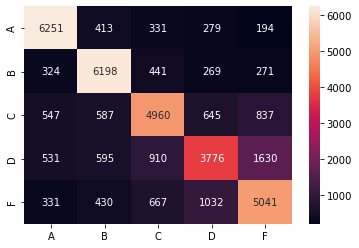

In [13]:
y_pred = log_reg.predict(X_test_scaled)
labels = ['A','B','C','D','F']
cm2 = confusion_matrix(y_test, y_pred,labels=labels)
sns.heatmap(cm2, annot=True, fmt=".0f", xticklabels=labels, yticklabels=labels)

In [28]:
ovr_clf = OneVsRestClassifier(LogisticRegression(max_iter=2000))
ovr_clf.fit(X_train_scaled,y_train)

preds = ovr_clf.predict(X_test_scaled)
probs = ovr_clf.predict_proba(X_test_scaled)

In [54]:
tpr = {}
fpr = {}
thresh ={}

for i,label in zip(range(5),labels):
    fpr[label],tpr[label],thresh[label] = roc_curve(y_test,probs[:,i],pos_label=label)

Text(0.5, 1.0, 'Receiver Operation Curve - ADASYN+LR')

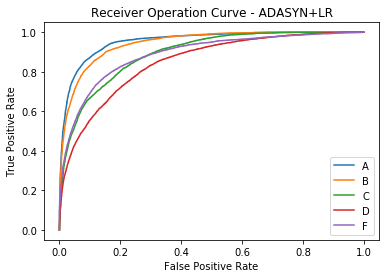

In [90]:
for label in labels:
    plt.plot(fpr[label],tpr[label],label=label)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operation Curve - ADASYN+LR')

# print(roc_auc_score(y_test.values.ravel(),probs,multi_class='ovr'))

In [91]:
y_probs = log_reg.predict_proba(X_test_scaled)

#roc_auc_score(y_test,y_probs,multi_class="ovr")
roc_auc_score(y_test.values.ravel(),y_probs,multi_class="ovr")

0.9134378925458295

In [103]:
# Co-efficient importance

feature_weights = pd.DataFrame(log_reg.coef_.transpose(),columns=log_reg.classes_)
feature_names = x_data.columns.to_frame().reset_index(drop=True)
feature_names.columns = ["features"]
feature_df = pd.merge(feature_names,feature_weights[labels],left_index=True,right_index=True)
feature_df.set_index("features",inplace=True)
feature_df.sort_values('A',ascending=False,inplace=True)
feature_df


,A,B,C,D,F
features,,,,,
tagforeign,5.996613,-5.196971,-2.700508,-1.762940,3.663805
taganimationmodeling,4.608390,-5.410043,-3.360441,2.375155,1.786938
maxprice,4.313681,4.803127,-1.983472,-6.771521,-0.361815
tagchess,4.148360,-3.174203,-2.328582,-0.247943,1.602367
tagdiplomacy,4.076368,-0.035283,-7.398073,1.671558,1.685429
...,...,...,...,...,...
tagcomicbook,-5.930931,2.276732,1.255004,1.213537,1.185659
tagartificialintelligence,-6.031976,-3.165415,1.363342,3.417121,4.416928
tagpermadeath,-7.122263,1.613812,3.498371,0.788964,1.221115


In [104]:
feature_df.sort_values('B',ascending=False)


,A,B,C,D,F
features,,,,,
maxprice,4.313681,4.803127,-1.983472,-6.771521,-0.361815
tagaudioproduction,-1.351119,3.867540,-0.770718,-2.687120,0.941417
tagstrategyrpg,-4.441759,2.984372,-0.339608,1.226496,0.570499
tagwarhammer40k,-1.381645,2.758628,0.650461,-0.560302,-1.467142
tagchoicesmatter,1.941576,2.685155,-0.881745,-1.078510,-2.666476
...,...,...,...,...,...
tagscoreattack,-3.400345,-5.745365,2.711718,3.252957,3.181035
tagfishing,1.445130,-5.986419,2.083280,1.563275,0.894734
tag1990s,3.854024,-6.027289,0.654679,0.026048,1.492539


## SMOTE over sampling

In [105]:
X_smote, y_smote = SMOTE().fit_sample(x_data, y)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state=5)
x_scaler = MinMaxScaler(feature_range=(0,5)).fit(X_train)

X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# y = y_train
# X = X_train_scaled

clf = LogisticRegression(max_iter=2000).fit(X_train_scaled, y_train)

In [106]:
print(f"Training Data Score: {clf.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {clf.score(X_test_scaled, y_test)}")

Training Data Score: 0.7080576307363927
Testing Data Score: 0.7039220917822839


              precision    recall  f1-score   support

           A       0.79      0.85      0.82      7487
           B       0.75      0.83      0.79      7425
           C       0.68      0.66      0.67      7581
           D       0.64      0.51      0.57      7486
           F       0.64      0.68      0.66      7501

    accuracy                           0.70     37480
   macro avg       0.70      0.70      0.70     37480
weighted avg       0.70      0.70      0.70     37480



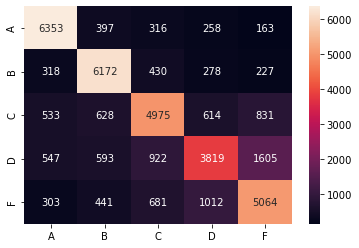

In [107]:
predictions = clf.predict(X_test_scaled)
print(classification_report(y_test,predictions))

y_pred = clf.predict(X_test_scaled)
labels = ['A','B','C','D','F']
cm2 = confusion_matrix(y_test, y_pred,labels=labels)
sns.heatmap(cm2, annot=True, fmt=".0f", xticklabels=labels, yticklabels=labels)

In [108]:
y_probs = clf.predict_proba(X_test_scaled)

roc_auc_score(y_test,y_probs,multi_class="ovr")

0.915741592819552

In [96]:
feature_weights = pd.DataFrame(clf.coef_.transpose(),columns=clf.classes_)
feature_names = x_data.columns.to_frame().reset_index(drop=True)
feature_names.columns = ["features"]
feature_df = pd.merge(feature_names,feature_weights[labels],left_index=True,right_index=True)
feature_df.set_index("features",inplace=True)
feature_df.sort_values('A',ascending=False,inplace=True)
feature_df

,A,B,C,D,F
features,,,,,
taganimationmodeling,6.004158,-1.482882,-4.669503,-2.738908,2.887134
tag1990s,5.217804,-6.106684,0.680980,-0.907942,1.115841
tagtouchfriendly,5.065982,-6.357532,-5.493685,3.066078,3.719158
tagforeign,4.268859,-3.808866,-1.226643,-2.353408,3.120058
maxprice,4.172205,8.125025,-3.450439,-7.437649,-1.409143
...,...,...,...,...,...
tagboardgame,-5.631476,2.577029,2.119107,0.464700,0.470640
tagmatch3,-5.637177,1.457621,2.105840,1.034469,1.039247
tagagriculture,-6.164117,4.567353,-5.983856,4.038846,3.541774


In [109]:
ovr_clf.fit(X_train_scaled,y_train)

preds = ovr_clf.predict(X_test_scaled)
probs = ovr_clf.predict_proba(X_test_scaled)

In [110]:
tpr = {}
fpr = {}
thresh ={}

for i,label in zip(range(5),labels):
    fpr[label],tpr[label],thresh[label] = roc_curve(y_test,probs[:,i],pos_label=label)

Text(0.5, 1.0, 'Receiver Operation Curve - SMOTE+LR')

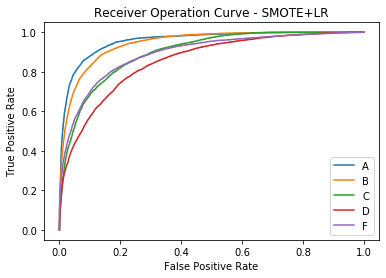

In [111]:
for label in labels:
    plt.plot(fpr[label],tpr[label],label=label)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operation Curve - SMOTE+LR')

# print(roc_auc_score(y_test.values.ravel(),probs,multi_class='ovr'))